## What should be presented in the case study:

#### 1. Degree (strength) distribution


#### 2. Two of the following characteristics:

    2.1 Average path length

    2.2 Clustering coefficient

    2.3 Small-worldness


 #### 3. At least one of centrality measures: 

    3.1 Degree centrality￼

    3.2 Closeness centrality￼

    3.3 Betweenness

    3.4 Prestige

    3.5 Decay centrality

#### 4. You need to consider at least 2 networks

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Data loading

In [3]:
path = "./data/"
fileName2019 = "Routes 2019 reworked v2.csv"
fileName2022 = "Routes 2022 reworked v2.csv"
fileAirports = "airports.csv"
routes2019 = pd.read_csv(filepath_or_buffer = path + fileName2019)
routes2022 = pd.read_csv(filepath_or_buffer = path + fileName2022)
airports = pd.read_csv(path+fileAirports)

# Data exploration

In [4]:
# Number of unique origins
routes2019.origin.nunique()

7295

In [5]:
#number of unique destinations
routes2022.origin.nunique()

9988

In [6]:
# calculate how many routes are duplicated in the dataset (weights are inferred from duplicated routes!)
routes2022.Routes.duplicated().sum()

0

In [7]:
routes2022.head()

,icao24,origin,origin airport,destination,destination airport,latitude_origin,longitude_origin,latitude_destination,longitude_destination,Routes
0,c07eee,CYYZ,Toronto Pearson International Airport,CYYC,Calgary International Airport,43.677200,-79.630600,51.113899,-114.019997,CYYZCYYC
1,4cac0f,RKSI,Incheon International Airport,LTBA,Istanbul Ataturk Airport,37.469101,126.450996,40.976898,28.814600,RKSILTBA
2,76bd4a,YSSY,Sydney Airport (Kingsford Smith Airport),RKSI,Incheon International Airport,-33.946098,151.177002,37.469101,126.450996,YSSYRKSI
3,406f74,YSSY,Sydney Airport (Kingsford Smith Airport),EGLL,Heathrow Airport,-33.946098,151.177002,51.470600,-0.461941,YSSYEGLL
4,a6d8ec,KTEB,Teterboro Airport,YSSY,Sydney Airport (Kingsford Smith Airport),40.850101,-74.060799,-33.946098,151.177002,KTEBYSSY


In [8]:
#calculate the sum of NA values in each column
routes2022.isna().sum()

icao24                     8
origin                     0
origin airport           305
destination                0
destination airport      288
latitude_origin          305
longitude_origin         305
latitude_destination     288
longitude_destination    288
Routes                     0
dtype: int64

# Basic Network Metrics and Plots

In [9]:
#create directed and undirected network object 
G2019_directed=nx.from_pandas_edgelist(routes2019, source = 'origin', target = 'destination', create_using=nx.DiGraph())
G2022_undirected = nx.from_pandas_edgelist(routes2022, source = "origin", target = "destination", create_using=nx.Graph())
G2022_directed=nx.from_pandas_edgelist(routes2022, source = 'origin', target = 'destination', create_using=nx.DiGraph())
G2022_undirected = nx.from_pandas_edgelist(routes2022, source = "origin", target = "destination", create_using=nx.Graph())

In [10]:
#Produce adjecancy matrices for 2022 and 2022 for the directed network
adj2019 = nx.to_pandas_adjacency(G2019_directed, dtype = int)
adj2022 = nx.to_pandas_adjacency(G2022_directed, dtype = int)
adj2019.head()

,YMML,LFPG,EGKK,FAOR,VABB,YSSY,EHAM,KEWR,ESSA,VOMM,...,EGEO,KIPT,92MI,EBHN,41NY,07VT,LKRO,EPOP,OK08,81NC
YMML,1,1,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
LFPG,0,1,1,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
EGKK,0,1,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
FAOR,1,1,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
VABB,0,1,0,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


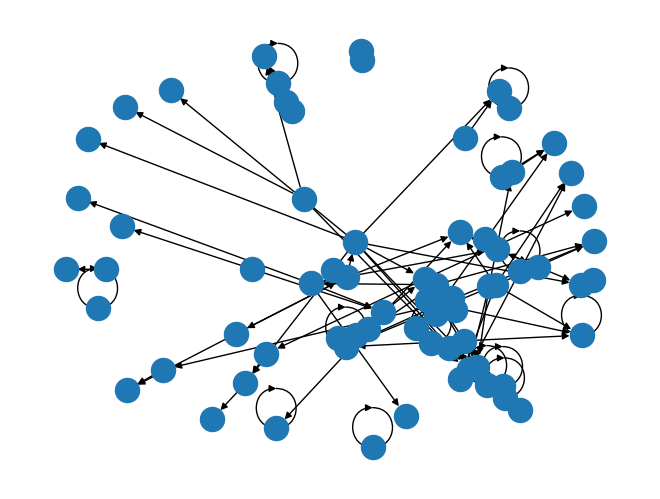

In [11]:
#draw a sample of the first 100 routes
G_sample = nx.from_pandas_edgelist(routes2019[0:100], source = 'origin', target = 'destination', create_using=nx.DiGraph())
nx.draw(G_sample)

## Degree

In [41]:
#caluculate in degrees 
in_degree2019 = dict(G2019_directed.in_degree)

In [13]:
#out degree
out_degree2019 = dict(G2019_directed.out_degree)

In [14]:
#calculate in-degree for each node using adjacency matrix (sum over rows)
#np.sum(adj2019, axis=0)
#np.sum(adj2022, axis = 1)

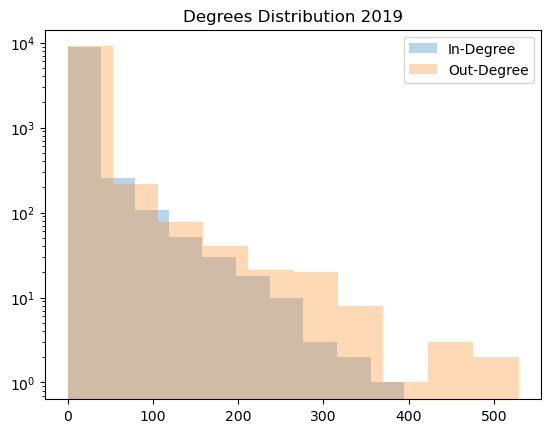

In [15]:
plt.hist(in_degree2019.values(),  alpha=0.3, log = True, label = 'In-Degree')
plt.hist(out_degree2019.values(),  alpha=0.3, log = True, label = 'Out-Degree')
plt.title('Degrees Distribution 2019')
plt.legend()

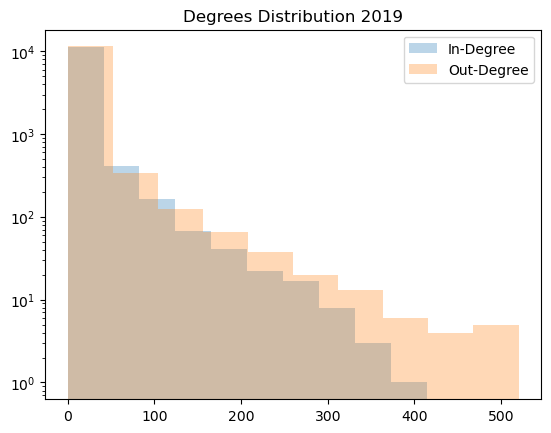

In [16]:
#caluculate in degrees 
in_degree2022 = dict(G2022_directed.in_degree)
out_degree2022 = dict(G2022_directed.out_degree)

plt.hist(in_degree2022.values(),  alpha=0.3, log = True, label = 'In-Degree')
plt.hist(out_degree2022.values(),  alpha=0.3, log = True, label = 'Out-Degree')
plt.title('Degrees Distribution 2019')
plt.legend()

## Strength

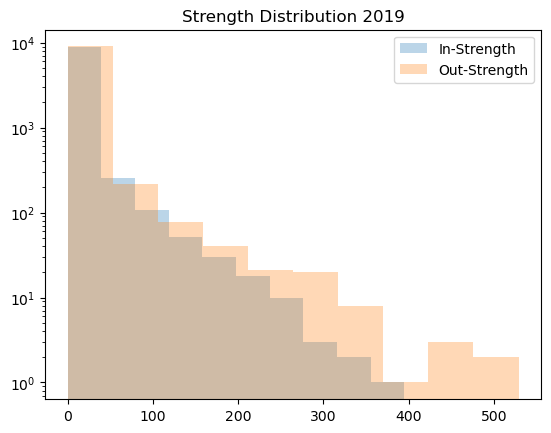

In [17]:
#strength distribution
in_strength2019 = dict(G2019_directed.in_degree(weight = 'weight'))
out_strength2019 = dict(G2019_directed.out_degree(weight = 'weight'))

plt.hist(in_strength2019.values(), bins = 10, alpha=0.3, log = True, label = 'In-Strength')
plt.hist(out_strength2019.values(), bins = 10, alpha=0.3, log = True, label = 'Out-Strength')
plt.title('Strength Distribution 2019')
plt.legend()


In [18]:
max_strength = max(out_strength2019, key=out_strength2019.get)
print(f"Max Out-Strength is at {max_strength} with {out_strength2019[max_strength]}.")

Max Out-Strength is at KORD with 529.


In [19]:
max_strength = max(in_strength2019, key=in_strength2019.get)
print(f"Max In-Strength is at {max_strength} with {out_strength2019[max_strength]}.")

Max In-Strength is at KTEB with 507.


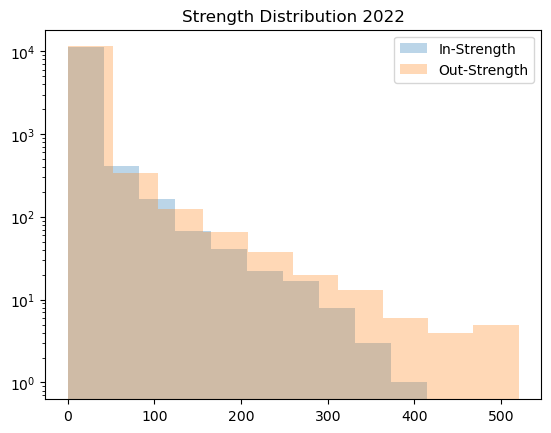

In [20]:
#strength distribution
in_strength2022 = dict(G2022_directed.in_degree(weight = 'weight'))
out_strength2022 = dict(G2022_directed.out_degree(weight = 'weight'))

plt.hist(in_strength2022.values(), bins = 10, alpha=0.3, log = True, label = 'In-Strength')
plt.hist(out_strength2022.values(), bins = 10, alpha=0.3, log = True, label = 'Out-Strength')
plt.title('Strength Distribution 2022')
plt.legend()


In [21]:
max_strength = max(out_strength2022, key=out_strength2022.get)
print(f"Max Out-Strength is at {max_strength} with {out_strength2019[max_strength]}.")

Max Out-Strength is at KORD with 529.


In [22]:
max_strength = max(in_strength2022, key=in_strength2022.get)
print(f"Max In-Strength is at {max_strength} with {out_strength2019[max_strength]}.")

Max In-Strength is at KTEB with 507.


## Distance measures

In [39]:
from networkx.algorithms.distance_measures import diameter
from networkx import average_shortest_path_length

In [33]:
# Returns the biggest giant strongly connected component in the network
G2019_directed_connected = G2019_directed.subgraph(sorted(nx.strongly_connected_components(G2019_directed), key = len, reverse = True)[0])

In [ ]:
#Calculate the diameter (takes very long for entire dataset)
diameter(G2019_directed_connected)

In [ ]:
#Calculate the diameter (takes very long for entire dataset)
average_shortest_path_length(G2019_directed_connected)

## Centrality

In [37]:
# calculate degree centrality (how connected the node is)
nx.centrality.degree_centrality(G2019_directed)

{'YMML': 0.012869602212295255,
 'LFPG': 0.048925760476494363,
 'EGKK': 0.03286534779834078,
 'FAOR': 0.00872154860667943,
 'VABB': 0.012656881514571366,
 'YSSY': 0.020633907679217186,
 'EHAM': 0.055094660710487124,
 'KEWR': 0.06253988513082323,
 'ESSA': 0.027015528610933842,
 'VOMM': 0.007551584769198042,
 'EDDF': 0.05105296745373324,
 'RJBB': 0.010423314188470537,
 'EDDM': 0.046266751754945754,
 'UUEE': 0.02542012337800468,
 'KJFK': 0.050627526058285466,
 'OTHH': 0.02318655605190385,
 'YBCS': 0.0031908104658583277,
 'KLAX': 0.055094660710487124,
 'SPJC': 0.00946607104871304,
 'OMDB': 0.032333546054031055,
 'KORD': 0.09029993618379067,
 'KBOS': 0.051584769198042967,
 'WMKK': 0.014571367794086364,
 'PANC': 0.019570304190597743,
 'WSSS': 0.01978302488832163,
 'YPPH': 0.006275260582854711,
 'RCTP': 0.0129759625611572,
 'VHHH': 0.025101042331418844,
 'ELLX': 0.02520740268028079,
 'MMTJ': 0.003616251861306105,
 'EBLG': 0.018400340353116357,
 'VTBS': 0.017017655817911082,
 'RJAA': 0.01701765

In [ ]:
# Calculating betweenness centrality (how important the node is in terms of connecting other nodes)
nx.centrality.betweenness_centrality(G2019_directed)

In [ ]:
# Calculating closeness centrality (how easily a node can reach other nodes)
nx.centrality.closeness_centrality(G2019_directed)